In [2]:
import pandas as pd

# import data
df = pd.read_csv('./Data/bank-full.csv', sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
df.shape

(45211, 17)

In [4]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [5]:
# Check if all rows has subscribed column = "no" when duration = 0
# 'duration' should not be a preditor because at the time of prediction, we don't have value for field 'duration' yet. 
# Otherwise, it will cause data leakage issue because at the time of prediction on production env, there is a missing feature (duration)
# in predicting outcome, model will perform poorly with low accuracy.
df_dur = df[df['duration'] == 0]
print(df_dur['y'].unique())

['no']


In [6]:
# check missing value
missing_data = df.isnull()
isMissing = False
# missing_data.head()
for column in missing_data.columns.tolist():
    missing_count = missing_data[column].sum()
    if missing_count > 0:
        print(f"column {column}: {missing_count} missing values")
        isMissing = True
if (not missing_count):
    print("There is no missing value")

There is no missing value


In [7]:
# check duplicate rows
dup_row = df[df.duplicated()]
if dup_row.shape[0] > 0:
    print(dup_row) 
else:
    print("There is no duplicated row")


There is no duplicated row


In [8]:
# Check if the dataset is imbalance at the target column
target_count = df['y'].value_counts(normalize=True)
target_count

y
no     0.883015
yes    0.116985
Name: proportion, dtype: float64

From above output, we can see that this is an imbalance dataset

In [9]:
import numpy as np

# compute CI range for strategic decision
# we can use sample mean for business decision but the CI range will provide a more flexible and precise value range of sample mean
def ci_range(df,col_name):
    num_rows = df.shape[0]
    col_std = df[col_name].std()
    col_mean = df[col_name].mean()
    # margin of error = z*. standard_error
    # 95% confident level has z* = 1.96
    margin_of_error = 1.96*col_std/np.sqrt(num_rows)

    # print out the interval estimate for true population mean/actual average age of all CURRENT bank customers
    print(f"We are 95% confident that the true average {col_name} of all current customers is within the range [{round(col_mean-margin_of_error,3)},{round(col_mean+margin_of_error,3)}]")


In [10]:
# compute CI range for continuous random variables for threshold decisions
ci_range(df,'age')
ci_range(df,'balance')
ci_range(df,'day')
ci_range(df,'duration')
ci_range(df,'campaign')
ci_range(df,'pdays')
ci_range(df,'previous')

We are 95% confident that the true average age of all current customers is within the range [40.838,41.034]
We are 95% confident that the true average balance of all current customers is within the range [1334.206,1390.339]
We are 95% confident that the true average day of all current customers is within the range [15.73,15.883]
We are 95% confident that the true average duration of all current customers is within the range [255.789,260.537]
We are 95% confident that the true average campaign of all current customers is within the range [2.735,2.792]
We are 95% confident that the true average pdays of all current customers is within the range [39.275,41.121]
We are 95% confident that the true average previous of all current customers is within the range [0.559,0.602]


To compute the true population mean, we use sample mean and sample standard deviation to construct a confidence interval 

We are 95% confident that the true average age of all current customers is within the range [40.838,41.034]
--> We are 95% confident that the interval [40.838,41.034] contains the true population mean age
--> Based on a 95% confidence interval, the average age of current customers is above 40.(threshold decision)
--> Shift budget toward channels with higher engagement/interaction (email,phone,web UX,...) for 40+ users.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [12]:
df.describe(include='all')

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
count,45211.000000,45211,45211,45211,45211,45211.000000,45211,45211,45211,45211.000000,45211,45211.000000,45211.000000,45211.000000,45211.000000,45211,45211
unique,NaN,12,3,4,2,NaN,2,2,3,NaN,12,NaN,NaN,NaN,NaN,4,2
top,NaN,blue-collar,married,secondary,no,NaN,yes,no,cellular,NaN,may,NaN,NaN,NaN,NaN,unknown,no
freq,NaN,9732,27214,23202,44396,NaN,25130,37967,29285,NaN,13766,NaN,NaN,NaN,NaN,36959,39922
mean,40.936210,NaN,NaN,NaN,NaN,1362.272058,NaN,NaN,NaN,15.806419,NaN,258.163080,2.763841,40.197828,0.580323,NaN,NaN
std,10.618762,NaN,NaN,NaN,NaN,3044.765829,NaN,NaN,NaN,8.322476,NaN,257.527812,3.098021,100.128746,2.303441,NaN,NaN
min,18.000000,NaN,NaN,NaN,NaN,-8019.000000,NaN,NaN,NaN,1.000000,NaN,0.000000,1.000000,-1.000000,0.000000,NaN,NaN
25%,33.000000,NaN,NaN,NaN,NaN,72.000000,NaN,NaN,NaN,8.000000,NaN,103.000000,1.000000,-1.000000,0.000000,NaN,NaN
50%,39.000000,NaN,NaN,NaN,NaN,448.000000,NaN,NaN,NaN,16.000000,NaN,180.000000,2.000000,-1.000000,0.000000,NaN,NaN
75%,48.000000,NaN,NaN,NaN,NaN,1428.000000,NaN,NaN,NaN,21.000000,NaN,319.000000,3.000000,-1.000000,0.000000,NaN,NaN


**I. Business insight extraction**
  
  **1. Correlation between the target value and the numerical variables**

**Doing the hypothesis testing to answer for question: Do people who subcribed have different average age than those who didn't**
- If we find:
  + Large, significant difference in mean age → subscribers are typical older/younger than non-subscribers, age is likely useful as a predictor 
  + No real difference → age might be weak as a predictor on its own.
- Because we are comparing the mean of a numberic variable (age) between 2 independent groups (subscribed vs non subscribed), we will use 2 sample t-test framework)
- Null hypothesis H0: the population mean age between subcribed and non-subcribed group is the same (M_yes = M_no)
- Alternative hypothesis: H1: The mean age is different between 2 groups (M_yes <> M_no)
- If **variances of both group are equal/similar then we use Student 2 sample t-test**
- If **variance of subscribed group is different from variance of non subscribed group then we use Welch's t-test**


In [13]:
# Split the dataset into 2 groups
age_subscribed = df[df['y']=='yes']['age']
age_not_subscribed = df[df['y'] =='no']['age']

print(age_subscribed.describe())
print(age_not_subscribed.describe())

count    5289.000000
mean       41.670070
std        13.497781
min        18.000000
25%        31.000000
50%        38.000000
75%        50.000000
max        95.000000
Name: age, dtype: float64
count    39922.000000
mean        40.838986
std         10.172662
min         18.000000
25%         33.000000
50%         39.000000
75%         48.000000
max         95.000000
Name: age, dtype: float64


Let's check if there is any outliers or heavy tail that can shift the mean

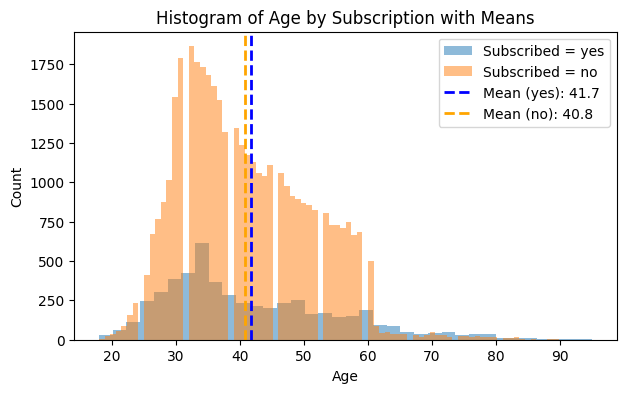

In [14]:
# Draw histogram to check shape, tails
import matplotlib.pyplot as plt
import numpy as np

# select 'age' value where 'y' column = 'yes'
# ages_yes = df.loc[df['y'] == 'yes', 'age']
# # select 'age' value where 'y' column = 'no'
# ages_no  = df.loc[df['y'] == 'no',  'age']

plt.figure(figsize=(7,4))
plt.hist(age_subscribed, bins='auto', alpha=0.5, label='Subscribed = yes')
plt.hist(age_not_subscribed,  bins='auto', alpha=0.5, label='Subscribed = no')

# Add vertical lines for the means
plt.axvline(age_subscribed.mean(), color='blue', linestyle='dashed', linewidth=2, label=f"Mean (yes): {age_subscribed.mean():.1f}")
plt.axvline(age_not_subscribed.mean(),  color='orange', linestyle='dashed', linewidth=2, label=f"Mean (no): {age_not_subscribed.mean():.1f}")

plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Histogram of Age by Subscription with Means')
plt.legend()
plt.show()


The "not subscribed" group (orange) is large, concentrated between 25-60 years

The "subscribed" group (blue) is much smaller, concentrated between 25-60. Right tail of both groups extend up to about 80-90 years which is a few older clients

--> The distribution is not perfectly normal, right skewed (long tail on the right side) and uneven sample sizes (the "not subsribed" group is larger than the "subscribed" group)

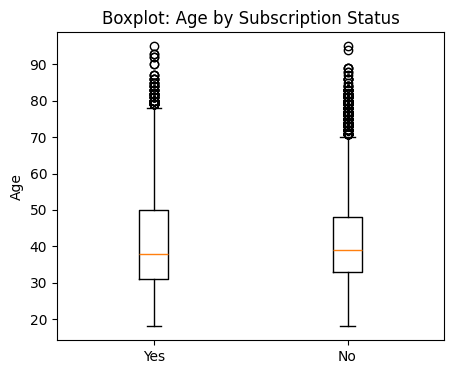

In [15]:
# Boxplot to check if there is any outliers
plt.figure(figsize=(5,4))
plt.boxplot(
    # [df.loc[df['y']=='no','age'], df.loc[df['y']=='yes','age']],
    [age_subscribed, age_not_subscribed],
    tick_labels=['Yes', 'No'],
    # showfliers=True
)
plt.title('Boxplot: Age by Subscription Status')
plt.ylabel('Age')
plt.show()

- Median age of both groups is around 37-39
- Interquartile ranges (boxes) overlap heavily suggesting a small difference in median as well as the mean
- There are many outliers in 2 groups
- The median of both groups moves below the central box and distance between median and upper whisker is longer than the distance between median and lower whisker indicating assymetric and right-skewed distributions


In [16]:
# Print the variance of both data groups
print(np.var(age_subscribed), np.var(age_not_subscribed))

182.15565741616854 103.48046195467694


Since the variances between the two groups differ substantially (182.16 vs 103.48), Welch’s t-test test is appropriate to compare the 2 population means

**Let's run Welch's t-test to see how different between the 2 population means**

In [17]:
import numpy as np
from scipy.stats import ttest_ind, t

# yes = df.loc[df['y']=='yes','age'].dropna()
# no  = df.loc[df['y']=='no','age'].dropna()

# Welch t-test (means)
# equal_var=False: the variances between 2 groups are not the same
t_stat, p = ttest_ind(age_subscribed, age_not_subscribed, equal_var=False)

# Mean diff and 95% CI
m_diff = age_subscribed.mean() - age_not_subscribed.mean()
n1, n2 = len(age_subscribed), len(age_not_subscribed)
# compute sample variance of subscribed ages and non subscribed ages
# ddof=1 → “degrees of freedom = 1” to subtract 1 in denominator when computing sample variance s1, s2
# Using n - 1 to fix the downward bias issue (the sample variance tends to be smallers than it should be on average) 
# that happens if we divide by n
s1, s2 = age_subscribed.var(ddof=1), age_not_subscribed.var(ddof=1)
# standard error (SE) of the difference in means under Welch’s t-test
se = np.sqrt(s1/n1 + s2/n2)

# compute degree of freedome for Welch's test
df_w = (s1/n1 + s2/n2)**2 / ((s1**2)/((n1**2)*(n1-1)) + (s2**2)/((n2**2)*(n2-1)))
# compute critical value for a 95% CI
tcrit = t.ppf(0.975, df_w)
# compute 95% confidence interval for the mean difference
ci = (m_diff - tcrit*se, m_diff + tcrit*se)

# Cohen's d (effect size) for practical significance
# compute pooled standard deviation
sp = np.sqrt((age_subscribed.var(ddof=1) + age_not_subscribed.var(ddof=1))/2)
d = m_diff / sp

print(f"Welch t={t_stat:.3f}, p={p:.3g}")
print(f"Mean difference (subscribed - non subscribed) = {m_diff:.2f} years")
print(f"95% CI = [{ci[0]:.2f}, {ci[1]:.2f}] years")
print(f"Cohen's d(effect size for 2 sample t-test = the size of the difference) = {d:.2f}  # ~0.2 small, ~0.5 medium, ~0.8 large")


Welch t=4.318, p=1.6e-05
Mean difference (subscribed - non subscribed) = 0.83 years
95% CI = [0.45, 1.21] years
Cohen's d(effect size for 2 sample t-test = the size of the difference) = 0.07  # ~0.2 small, ~0.5 medium, ~0.8 large


- p value < 0.05, we reject H0
--> Statistically, the population mean age differs between subscribers and non-subscribers.
- Sample (descriptive): In our sample, subscribers were on average 0.83 years older than non-subscribers (sample mean difference = 0.83 years --> This is a true statement about the sample)
- Population (inferential): We estimate the population mean difference to be 0.83 years (this is just a prediction based on the sample), with 95% confidence that the true population mean difference lies in [0.45, 1.21] which means that on average, subscribers are between 0.45 and 1.21 years older than non subscribers 
- Welch's t-test shows the difference in population mean between the subscriber and non-subscriber groups is statistically significant (p < 0.05) but because d=0.07 (the difference is very tiny with high overlap), <span style="color:red">this difference is not practically meaningful</span>

**Let's run Mann-Whitney U test to evaluate whether one group tends to have higher age values than the other**
- H0: The probability that a randomly selected subscriber is older than non-subscriber is equal to the probability that the subscriber is younger than non-subscriber
- H1: The probability that a randomly selected subscriber is older than a non-subscriber is higher/lower than the probability that the subscriber is younger than non-subscriber. *(This does not mean that the **mean age** of subscribers is higher because the mean age can be higher due to a few very old subscribers but subscribers do not generally tend to be older - most subscribers might still be younger)*

In [18]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu

# 1) Extract & clean groups
# yes = pd.to_numeric(df.loc[df['y'] == 'yes', 'age'], errors='coerce').dropna().to_numpy()
# no  = pd.to_numeric(df.loc[df['y'] == 'no',  'age'], errors='coerce').dropna().to_numpy()

n1, n2 = len(age_subscribed), len(age_not_subscribed)
print(f"n_yes={n1}, n_no={n2}")

# 2) Mann–Whitney U test (two-sided; robust to non-normality)
U, p = mannwhitneyu(age_subscribed, age_not_subscribed, alternative='two-sided', method='auto')
print(f"Mann–Whitney U = {U:.0f},  p-value = {p:.6g}")

# 3) Effect sizes from U
# Probability of superiority (common-language effect): P(X_yes > X_no)
PS = U / (n1 * n2)
# Rank-biserial correlation == Cliff's delta for two independent samples
# cliffs_delta = 2*PS - 1

print(f"Common language effect size = {PS:.3f}  # ~0.5 means almost no difference")
# print(f"Cliff's delta = {cliffs_delta:.3f}          # -1..1; 0 ≈ no effect")

# 4) Median difference (location shift in original units)
med_yes = np.median(age_subscribed)
med_no  = np.median(age_not_subscribed)
med_diff = med_yes - med_no
print(f"Median(age): yes={med_yes:.2f}, no={med_no:.2f}, median difference = {med_diff:.2f} years")


n_yes=5289, n_no=39922
Mann–Whitney U = 103915110,  p-value = 0.0628179
Common language effect size = 0.492  # ~0.5 means almost no difference
Median(age): yes=38.00, no=39.00, median difference = -1.00 years


- p-value = 0.0628179 > 0.05: We fail to reject H0 which means the probability that a randomly selected subscriber is older than non-subscriber is equal to the probability that the subscriber is younger than non-subscriber
- Common language effect size = 0.492, so the prob to randomly picking a person in subscriber group older than non-subscriber group P(age_yes > age_no) = the prob to randomly picking a person in subscriber group younger than non-subscriber group P(age_yes < age_no) --> not better than flipping a coin and not statistical significant
- The middle age of subscriber group is 1 year younger than the one of non-subscriber group which means a tiny difference

In [19]:
# Split the dataset into 2 groups based on 'balance' column
balance_subscribed = df[df['y']=='yes']['balance']
balance_not_subscribed = df[df['y'] =='no']['balance']

print(balance_subscribed.describe())
print(balance_not_subscribed.describe())

count     5289.000000
mean      1804.267915
std       3501.104777
min      -3058.000000
25%        210.000000
50%        733.000000
75%       2159.000000
max      81204.000000
Name: balance, dtype: float64
count     39922.000000
mean       1303.714969
std        2974.195473
min       -8019.000000
25%          58.000000
50%         417.000000
75%        1345.000000
max      102127.000000
Name: balance, dtype: float64


Let's visualize the 2 groups' distribution on histogram and boxplot

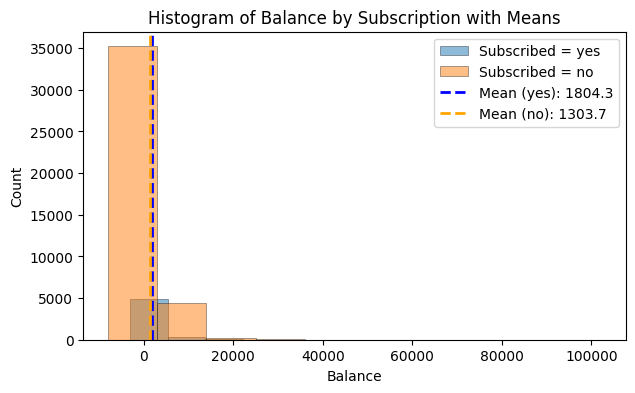

In [20]:
# Draw histogram to check shape, tails
# import matplotlib.pyplot as plt
# import numpy as np

# select 'balance' value where 'y' column = 'yes'
# balance_yes = df.loc[df['y'] == 'yes', 'balance']
# # select 'age' value where 'y' column = 'no'
# balance_no  = df.loc[df['y'] == 'no',  'balance']

plt.figure(figsize=(7,4))
plt.hist(balance_subscribed, bins=10, alpha=0.5, label='Subscribed = yes', edgecolor = 'black', linewidth=0.5)
plt.hist(balance_not_subscribed,  bins=10, alpha=0.5, label='Subscribed = no', edgecolor = 'black', linewidth=0.5)

# Add vertical lines for the means
plt.axvline(balance_subscribed.mean(), color='blue', linestyle='dashed', linewidth=2, label=f"Mean (yes): {balance_subscribed.mean():.1f}")
plt.axvline(balance_not_subscribed.mean(),  color='orange', linestyle='dashed', linewidth=2, label=f"Mean (no): {balance_not_subscribed.mean():.1f}")

plt.xlabel('Balance')
plt.ylabel('Count')
plt.title('Histogram of Balance by Subscription with Means')
plt.legend()
plt.show()


- The distribution of non-subscriber group is much larger, most value concentrates arround 0 (tallest bars are near 0). It's strongly right-skewed with a long tail extends up to value 38,000 euros
- The subscriber group is smaller, most balances are also near 0 with a slight right-skewed shape and a tail extending up to 20,000 euros
- Overall, the distribution is totally not normal, right-skewed and uneven in sample sizes

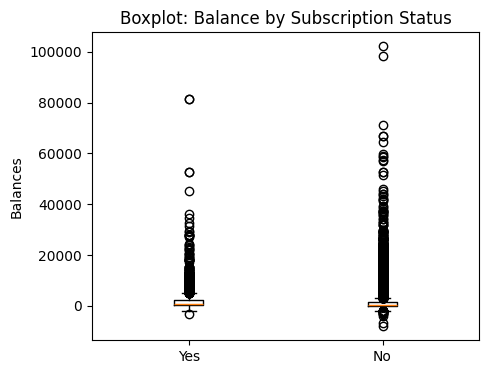

In [21]:
# Boxplot to check if there is any outliers
plt.figure(figsize=(5,4))
plt.boxplot(
    # [df.loc[df['y']=='no','balance'], df.loc[df['y']=='yes','balance']],
    [balance_subscribed, balance_not_subscribed],
    tick_labels=['Yes', 'No'],
    # showfliers=True
)
plt.title('Boxplot: Balance by Subscription Status')
plt.ylabel('Balances')
plt.show()

- The median of both groups is arround 0 euro
- The interquartile ranges (the box) of 2 groups are heavily overlap suggesting a very small difference in median between subscribers and non-subscribers.
- There are a lot of unusually high/low value points which are outside the typical range in both groups indicating strong skewness. Therefore, the mean does not represent the behaviour of the whole distribution, we should use median instead as a metric in doing hypothesis testing

**Let's run Mann-Whitney U test to evaluate whether one group tends to have higher balance values than the other**
- H0: The probability that a randomly selected subscriber has higher balance than non-subscriber is equal to the probability that the subscriber has lower balance than non-subscriber
- H1: The probability that a randomly selected subscriber has higher balance than a non-subscriber is higher/lower than the probability that the subscriber has lower balance than non-subscriber.

In [22]:
# import numpy as np
# import pandas as pd
# from scipy.stats import mannwhitneyu

# 1) Extract & clean groups
# yes = pd.to_numeric(df.loc[df['y'] == 'yes', 'balance'], errors='coerce').dropna().to_numpy()
# no  = pd.to_numeric(df.loc[df['y'] == 'no',  'balance'], errors='coerce').dropna().to_numpy()

n1, n2 = len(balance_subscribed), len(balance_not_subscribed)
print(f"n_yes={n1}, n_no={n2}")

# 2) Mann–Whitney U test (two-sided; robust to non-normality)
U, p = mannwhitneyu(balance_subscribed, balance_not_subscribed, alternative='two-sided', method='auto')
print(f"Mann–Whitney U = {U:.0f},  p-value = {p:.6g}")

# 3) Effect sizes from U
# Probability of superiority (common-language effect): P(X_yes > X_no)
PS = U / (n1 * n2)
# Rank-biserial correlation == Cliff's delta for two independent samples
# cliffs_delta = 2*PS - 1

print(f"Common language effect size = {PS:.3f}  # ~0.5 means almost no difference")
# print(f"Cliff's delta = {cliffs_delta:.3f}          # -1..1; 0 ≈ no effect")

# 4) Median difference (location shift in original units)
med_yes = np.median(balance_subscribed)
med_no  = np.median(balance_not_subscribed)
med_diff = med_yes - med_no
print(f"Median(balance): yes={med_yes:.2f}, no={med_no:.2f}, median difference = {med_diff:.2f} euros")


n_yes=5289, n_no=39922
Mann–Whitney U = 124589984,  p-value = 6.59385e-101
Common language effect size = 0.590  # ~0.5 means almost no difference
Median(balance): yes=733.00, no=417.00, median difference = 316.00 euros


- p-value << 0.05 so we reject the null hypothesis. This indicates that *the difference in balance distributions between subscriber group and non subscriber group is statistically significant*
- Common language effect size P(x_sub > y_nonsub) = 0.59 means that probability in randomly selecting a balance in subscriber group that greater than the random selected balance in non subscriber group is approximately 59%. Therefore, the subscribers are slightly more often have the higher balance then the non subscribers
- The median for subscribers is 316 euros higher than for non subscriber which is *a modest difference despite being statistically significant.*

**Perform hypothesis testing for all other numeric features**

In [23]:
campaign_yes = df[df['y']=="yes"]['campaign']
campaign_no = df[df['y']=="no"]['campaign']

pdays_yes = df[df['y']=="yes"]['pdays']
pdays_no = df[df['y']=="no"]['pdays']

previous_yes = df[df['y']=="yes"]['previous']
previous_no = df[df['y']=="no"]['previous']

# outcome_yes = df[df['y']=="yes"]['poutcome']
# outcome_no = df[df['y']=="no"]['poutcome']

print(previous_yes.describe())
print(previous_no.describe())


count    5289.000000
mean        1.170354
std         2.553272
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        58.000000
Name: previous, dtype: float64
count    39922.000000
mean         0.502154
std          2.256771
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        275.000000
Name: previous, dtype: float64


Let's observe the distribution of those variables in the below histograms and box plots

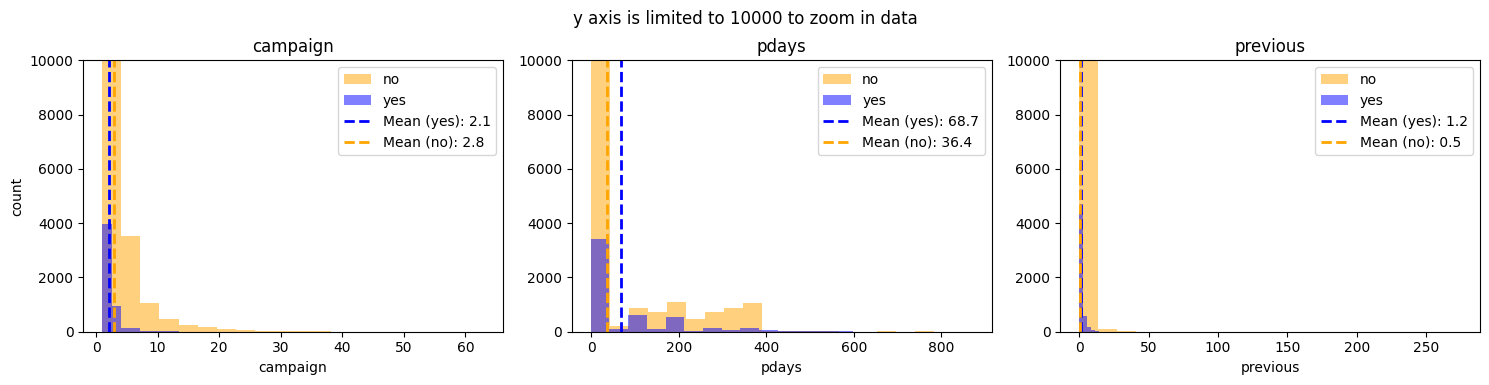

In [24]:
# create 1 row, 3 columns of subplots
fig, axes = plt.subplots(1, 3 ,figsize=(15,4))
# plt.ylim(0,15000)

# --- 1) campaign ---
axes[0].hist(campaign_no,  bins=20, alpha=0.5, color='orange', label='no')
axes[0].hist(campaign_yes, bins=20, alpha=0.5, color='blue', label='yes')
axes[0].axvline(campaign_yes.mean(), color='blue', linestyle='dashed', linewidth=2, label=f"Mean (yes): {campaign_yes.mean():.1f}")
axes[0].axvline(campaign_no.mean(),  color='orange', linestyle='dashed', linewidth=2, label=f"Mean (no): {campaign_no.mean():.1f}")
axes[0].set_ylim(0, 10000)   # adjust the upper bound of y axis
axes[0].set_title('campaign')
axes[0].set_xlabel('campaign')
axes[0].set_ylabel('count')
axes[0].legend()

# --- 2) pdays ---
axes[1].hist(pdays_no,  bins=20, alpha=0.5, color='orange', label='no')
axes[1].hist(pdays_yes, bins=20, alpha=0.5, color='blue', label='yes')
axes[1].axvline(pdays_yes.mean(), color='blue', linestyle='dashed', linewidth=2, label=f"Mean (yes): {pdays_yes.mean():.1f}")
axes[1].axvline(pdays_no.mean(),  color='orange', linestyle='dashed', linewidth=2, label=f"Mean (no): {pdays_no.mean():.1f}")
axes[1].set_ylim(0, 10000)   # adjust the upper bound of y axis
# axes[1].set_xlim(-5, 900) 
# axes[1].set_xticks([-1, 0, 100, 200, 300, 400, 500, 600, 700, 800, 900])
axes[1].set_title('pdays')
axes[1].set_xlabel('pdays')
axes[1].legend()

# --- 3) previous ---
# use the log scale for y axis
axes[2].hist(previous_no,  bins=20, alpha=0.5, color='orange', label='no')
axes[2].hist(previous_yes, bins=20, alpha=0.5, color='blue', label='yes')
axes[2].axvline(previous_yes.mean(), color='blue', linestyle='dashed', linewidth=2, label=f"Mean (yes): {previous_yes.mean():.1f}")
axes[2].axvline(previous_no.mean(),  color='orange', linestyle='dashed', linewidth=2, label=f"Mean (no): {previous_no.mean():.1f}")
axes[2].set_ylim(0, 10000)   # adjust the upper bound of y axis
axes[2].set_title('previous')
axes[2].set_xlabel('previous')
axes[2].legend()

# plt.title("y axis is limited to 10000 to zoom in data")
fig.suptitle("y axis is limited to 10000 to zoom in data", y=0.95)
plt.tight_layout()
plt.show()

Across all three variables, the sample size of non subscribed group is much larger than the subscribed group. None of the distributions appear normal, instead, they are strongly right-skewed with long tails.

Campaign:
- Most observations for both groups fall between 2-3 contacts showing that most of customers were contacted only a few times
- Data is right-skewed with long tail extending up to 40 contacts at the non-subscriber group

pdays:
- Most of value concentrates in the range 0-40 days for both subscribers and non-subscribers.
- Data is right-skewed with long tail extending up to 600, 800 days for subscribers and non subscribers accordingly suggesting that there are a few customers that the bank hasn't contacted for long time.

previous:
- Majority of value is around 0 contact, with only a small number of customers having more than a few previous contacts
- The distribution is also right-skewed with sparse, long tail extending up to 250 contacts for non-subscriber group

Bin edges: [  0.    13.75  27.5   41.25  55.    68.75  82.5   96.25 110.   123.75
 137.5  151.25 165.   178.75 192.5  206.25 220.   233.75 247.5  261.25
 275.  ]
Counts: [39795   110    15     1     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     1]


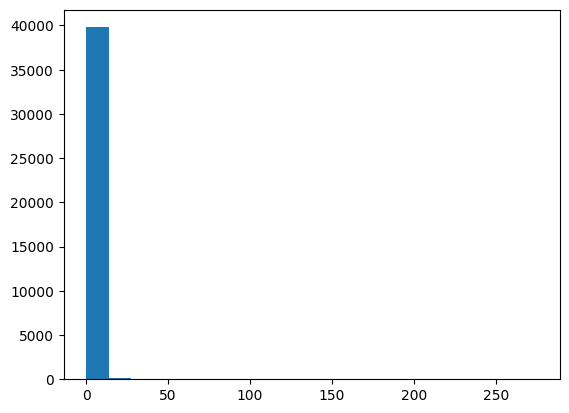

In [25]:
counts, bin_edges, _ = plt.hist(previous_no, bins=20)
print("Bin edges:", bin_edges)
print("Counts:", counts.astype(int))

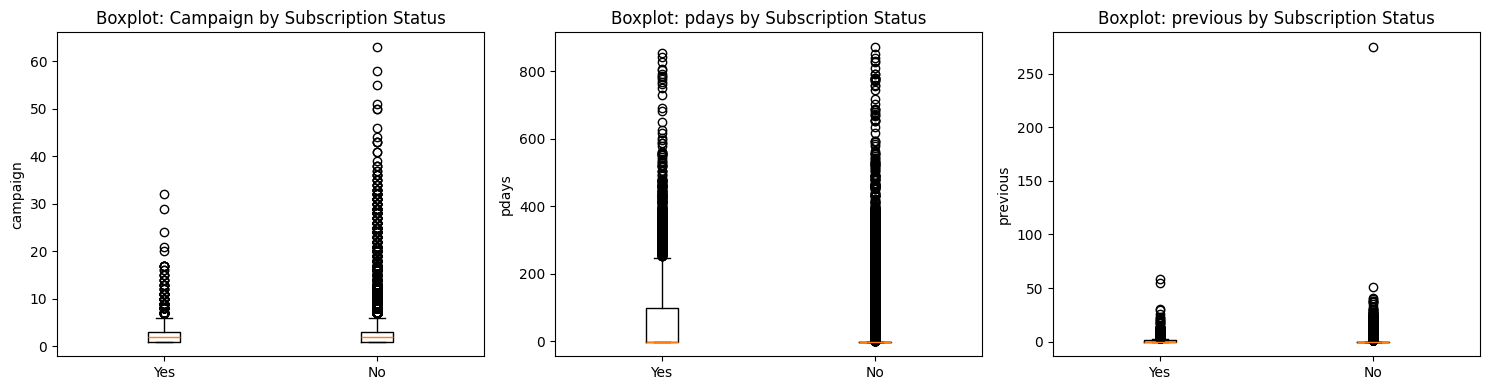

In [26]:
# drawing the box plots
# create 1 row, 3 columns of subplots
fig, axes = plt.subplots(1, 3 ,figsize=(15,4))
# plt.ylim(0,15000)

# --- 1) campaign ---
axes[0].boxplot(
    # [df.loc[df['y']=='no','balance'], df.loc[df['y']=='yes','balance']],
    [campaign_yes, campaign_no],
    tick_labels=['Yes', 'No'],
    # showfliers=True
)
axes[0].set_title('Boxplot: Campaign by Subscription Status')
axes[0].set_ylabel('campaign')
# axes[0].legend()

# --- 2) pdays ---
axes[1].boxplot(
    # [df.loc[df['y']=='no','balance'], df.loc[df['y']=='yes','balance']],
    [pdays_yes, pdays_no],
    tick_labels=['Yes', 'No'],
    # showfliers=True
)
axes[1].set_title('Boxplot: pdays by Subscription Status')
axes[1].set_ylabel('pdays')
# axes[1].legend()

# --- 3) previous ---
axes[2].boxplot(
    # [df.loc[df['y']=='no','balance'], df.loc[df['y']=='yes','balance']],
    [previous_yes, previous_no],
    tick_labels=['Yes', 'No'],
    # showfliers=True
)
axes[2].set_title('Boxplot: previous by Subscription Status')
axes[2].set_ylabel('previous')
# axes[2].legend()

plt.tight_layout()
plt.show()

Overall, there are a lot of unsually high value points that are outside of typical range for both groups.

Campaign:
- The interquartile ranges (the box) of both groups are heavily overlapped indicating there is likely no significant difference between their mean as well as median
- Median value of both groups are similar and around 2 contacts

pdays:
- Median value of both groups are around 0 days
- The distribution is strongly right-skewed due to the very long tail on the right

previous:
- Most of data point is around 0 indicating majority of customers have no contact before

**Perform Mann-Whitney U test for the numeric features**

In [27]:
def per_whitney(subscribed, nonsubscribed):
    n1, n2 = len(subscribed), len(nonsubscribed)
    print(f"n_yes={n1}, n_no={n2}")

    # 2) Mann–Whitney U test (two-sided; robust to non-normality)
    U, p = mannwhitneyu(subscribed, nonsubscribed, alternative='two-sided', method='auto')
    print(f"Mann–Whitney U = {U:.0f},  p-value = {p:.6g}")

    # 3) Effect sizes from U
    # Probability of superiority (common-language effect): P(X_yes > X_no)
    PS = U / (n1 * n2)

    print(f"Common language effect size = {PS:.3f}  # ~0.5 means almost no difference")
    
    # 4) Median difference (location shift in original units)
    med_yes = np.median(subscribed)
    med_no  = np.median(nonsubscribed)
    med_diff = med_yes - med_no
    print(f"Median: yes={med_yes:.2f}, no={med_no:.2f}, median difference = {med_diff:.2f}")


In [28]:
per_whitney(campaign_yes, campaign_no)

n_yes=5289, n_no=39922
Mann–Whitney U = 90300544,  p-value = 1.94849e-71
Common language effect size = 0.428  # ~0.5 means almost no difference
Median: yes=2.00, no=2.00, median difference = 0.00


- p-value is far below 0.05 so we reject the null hypothesis. This indicates that the difference in number of contacts made during this campaign between subscribers and non subscribers is statistically significant
- Common language effect size P(x_sub > y_nonsub) = 0.428 means that when selecting one person from each group at random, the probability that subscriber has more contacts than non subscriber is only 42.8%. Since this is below 0.5, it is more likely that the non subscriber has higher number of contacts than the subscriber. However, this difference is small in practical terms (close to 0.5)
- The median for both group is the same despite statistical significance. This indicates that the groups differ mainly in the distribution shape (the spread and tails), not in the central value.

In [29]:
per_whitney(pdays_yes, pdays_no)

n_yes=5289, n_no=39922
Mann–Whitney U = 125257746,  p-value = 2.48412e-235
Common language effect size = 0.593  # ~0.5 means almost no difference
Median: yes=-1.00, no=-1.00, median difference = 0.00


The pdays feature has similar test result as the campaign feature which means that:
- The difference in number of passed days since the last contact between 2 groups is statistically significant.
- It is more likely that a subscriber has higher number of passed days compared to a non subscriber. However, this difference is small in practical terms (close to 0.5)
- The median for both groups is the same (-1) despite statistical significance. This suggests that the main difference comes from the distribution shape (the spread and tails), not in the central location

In [30]:
per_whitney(previous_yes, previous_no)

n_yes=5289, n_no=39922
Mann–Whitney U = 127174833,  p-value = 3.49182e-283
Common language effect size = 0.602  # ~0.5 means almost no difference
Median: yes=0.00, no=0.00, median difference = 0.00


The previous feature shows similar result as the campain and pdays features:
- The difference in number of previous contacts between 2 group is statistically significance.
- There is more chance that a subsciber has more previous contacts than a non subscriber. However, this difference is small in practical terms 
- There is no difference in median between 2 group indicating the main difference comes from the distribution shape (the spread and tails), not in the central value

**2. Correlation between the target value and the categorical variables**

In [31]:
import pandas as pd
from scipy.stats import chi2_contingency
import numpy as np

# use the Chi-Square Test of Independence to see if a relationship exists
def chi_test(feature):
    is_associate = False
    # compute contingency table that counts how often each combination of 2 categorical variables occurs
    # For ex: 
    #       B1      B2      B3
    #  A1   10      20      30
    #  A2   5       25      10
    table = pd.crosstab(df[feature], df['y'])
    chi2, p, dof, expected = chi2_contingency(table)
    print("==============================")
    print(f"Feature: {feature}")
    print("p-value =", p)
    if p < 0.05:
        print(f"The feature {feature} is associated with subscription")
        is_associate = True
    else:
        print(f"The feature {feature} has no association with subscription")
    # print(table, "\n")
    return table, is_associate

# use Cramer's V to measure how strong is this relationship
# Range value is from 0 to 1
def cramers_v(confusion_matrix):
    # [0]: means to extract only the Chi-square statistic out of 4 returned results
    chi2 = chi2_contingency(confusion_matrix)[0]

    # First .sum(): sums each column
    # Second .sum(): sums those column totals
    n = confusion_matrix.sum().sum()

    # compute phi squared by normalizing Chi-square statistic by sample size
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(r-1, k-1))

def interpret_result(cramer_score):
    if cramer_score <= 0.1:
        print("The association is very weak")
    elif cramer_score > 0.1 and cramer_score <= 0.2:
        print("The association is weak")
    elif cramer_score > 0.2 and cramer_score <= 0.3:
        print("The association is moderate")
    elif cramer_score > 0.3 and cramer_score <= 0.5:
        print("The association is strong")
    else:
        print("The association is very strong")

def check_relationship(feature):
    contigency_table, is_associate = chi_test(feature)
    if is_associate:
        cramers_v_val = cramers_v(contigency_table)
        print(f"Cramer's V ({feature}) =", cramers_v_val)
        interpret_result(cramers_v_val)
        if cramers_v_val > 0.3:
            print(contigency_table)

In [32]:
check_relationship("job")
check_relationship("marital")
check_relationship("education")

Feature: job
p-value = 3.337121944935502e-172
The feature job is associated with subscription
Cramer's V (job) = 0.13599047177178863
The association is weak
Feature: marital
p-value = 2.1450999986791792e-43
The feature marital is associated with subscription
Cramer's V (marital) = 0.06592569856952814
The association is very weak
Feature: education
p-value = 1.6266562124072994e-51
The feature education is associated with subscription
Cramer's V (education) = 0.07269547575269042
The association is very weak


In [33]:
check_relationship("default")
check_relationship("housing")
check_relationship("loan")
check_relationship("contact")


Feature: default
p-value = 2.4538606753508344e-06
The feature default is associated with subscription
Cramer's V (default) = 0.022160340914956507
The association is very weak
Feature: housing
p-value = 2.918797605076633e-192
The feature housing is associated with subscription
Cramer's V (housing) = 0.1391034505051807
The association is weak
Feature: loan
p-value = 1.665061163492756e-47
The feature loan is associated with subscription
Cramer's V (loan) = 0.06809122911100252
The association is very weak
Feature: contact
p-value = 1.251738325340638e-225
The feature contact is associated with subscription
Cramer's V (contact) = 0.15135539788059024
The association is weak


In [34]:
check_relationship("poutcome")

Feature: poutcome
p-value = 0.0
The feature poutcome is associated with subscription
Cramer's V (poutcome) = 0.3116626167998104
The association is strong
y            no   yes
poutcome             
failure    4283   618
other      1533   307
success     533   978
unknown   33573  3386


In [35]:
succ_yes_count = df[(df['y']=='yes') & (df['poutcome'] =='success')].shape[0]
succ_total = df[df['poutcome'] == 'success'].shape[0]

fail_yes_count = df[(df['y']=='yes') & (df['poutcome'] =='failure')].shape[0]
fail_total = df[df['poutcome'] == 'failure'].shape[0]

unknown_yes_count = df[(df['y']=='yes') & (df['poutcome'] =='unknown')].shape[0]
unknown_total = df[df['poutcome'] == 'unknown'].shape[0]

# subscription rate in success group
success_sub_rate = succ_yes_count/succ_total
print(f"subscription rate in success group: {success_sub_rate:.1%}")

# subscription rate in failure group
failure_sub_rate = fail_yes_count/fail_total
print(f"subscription rate in failure group: {failure_sub_rate:.1%}")

# subscription rate in unknown group (never contacted or missing)
unknow_sub_rate = unknown_yes_count/unknown_total
print(f"subscription rate in unknown group: {unknow_sub_rate:.1%}")

subscription rate in success group: 64.7%
subscription rate in failure group: 12.6%
subscription rate in unknown group: 9.2%


Business logic:
- People who said yes before are much more likely to say yes again this time (64.7%)
- People who said no before are more likely to say no again this time (12.6% say yes and 87.4% say no)
- People who were not contacted before or had unknown outcome last time is rarely to say yes this time (only 9.2% say yes)

In [36]:
# draw a bar plot of subscription rate of some categorical feature
def plot_conversion_rate(df, feature, target='y', positive='yes'):
    conv = (
        # split the df into groups by column 'feature'
        # for each group we look only at the target column
        df.groupby(feature)[target]
        # for each group we have a Series s of target values (yes/no)
        # (s==positive) creates a Boolean series: True where target == 'yes', False otherwise
        # In pandas/Numpy, True=1, False=0, so mean() of that Boolean Series = proportion of 'yes' in that group
          .apply(lambda s: (s == positive).mean())
        # sort the subscription rate descendingly
          .sort_values(ascending=False)
    )

    plt.figure(figsize=(6,4))
    conv.plot(kind='bar')
    plt.ylabel(f'{positive} rate')
    plt.xlabel(feature)
    plt.title(f'Conversion rate by {feature}')
    plt.ylim(0, 1)
    plt.grid(axis='y', alpha=0.3)
    plt.show()
    return conv


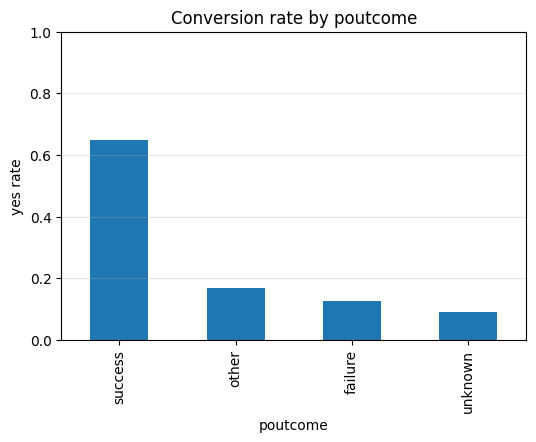

poutcome
success    0.647253
other      0.166848
failure    0.126097
unknown    0.091615
Name: y, dtype: float64

In [37]:
plot_conversion_rate(df, 'poutcome')

We can see that 'success' category has much higher conversion rate than others, there is large spread of conversion rate between groups. Knowing the groups of 'poutcome' pushes the predicted probability away from the overall average (the unsure prediction) and make our prediction closer to 0 or closer to 1 which means we are less uncertain. Therefore, the feature 'poutcome' is strongly associated with the target.

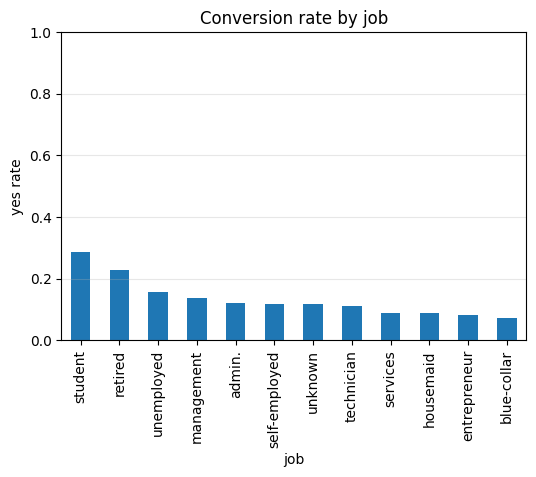

job
student          0.286780
retired          0.227915
unemployed       0.155027
management       0.137556
admin.           0.122027
self-employed    0.118429
unknown          0.118056
technician       0.110570
services         0.088830
housemaid        0.087903
entrepreneur     0.082717
blue-collar      0.072750
Name: y, dtype: float64

In [38]:
plot_conversion_rate(df, 'job')

Conversion rates are relatively similar across groups, providing limited information about the target. Hence, the association between feature and target value is weak

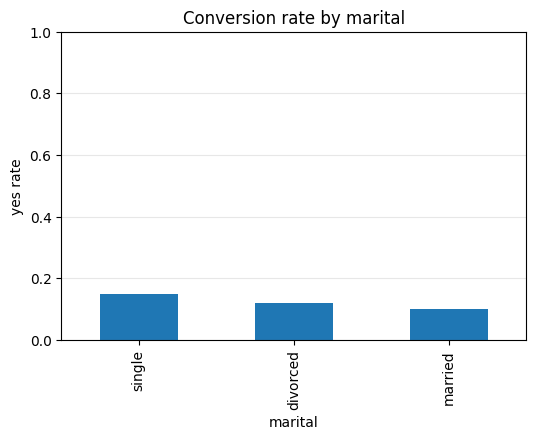

marital
single      0.149492
divorced    0.119455
married     0.101235
Name: y, dtype: float64

In [39]:
plot_conversion_rate(df, 'marital')

As all categories have relatively similar subscription rate between groups, the association between feature and target value is very weak

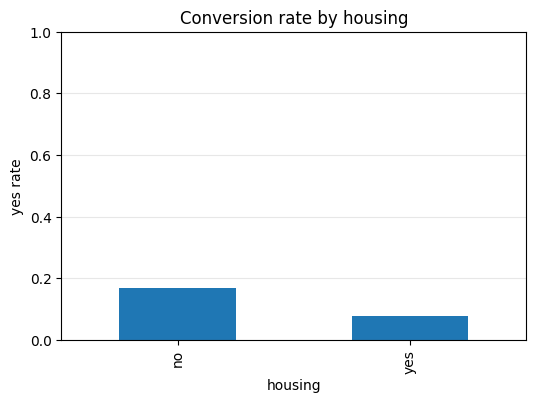

housing
no     0.167024
yes    0.077000
Name: y, dtype: float64

In [40]:
plot_conversion_rate(df, 'housing')

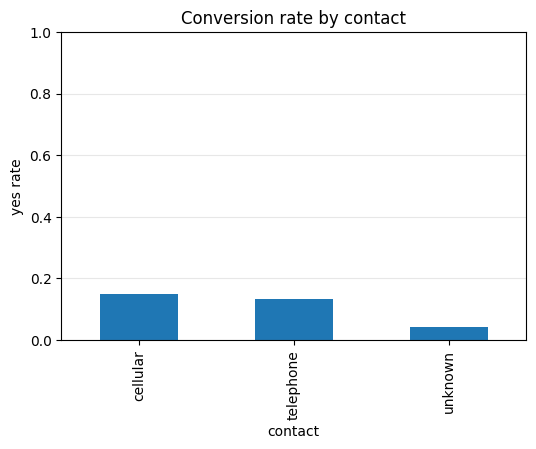

contact
cellular     0.149189
telephone    0.134205
unknown      0.040707
Name: y, dtype: float64

In [41]:
plot_conversion_rate(df, 'contact')

**Let's check conversion rate by month to answer the question: Is subscription independent of contact month?**

In [42]:
# Use Chi square test to check the relationship
check_relationship("month")

Feature: month
p-value = 0.0
The feature month is associated with subscription
Cramer's V (month) = 0.2602370422991876
The association is moderate


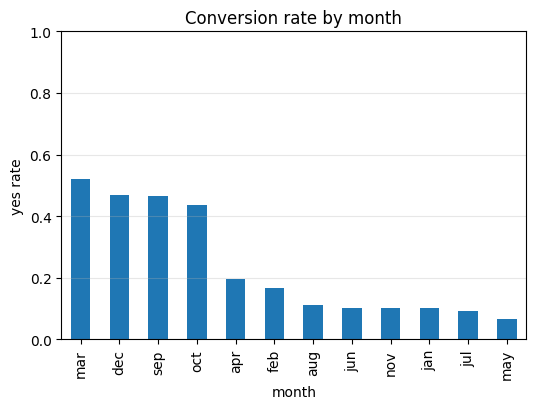

month
mar    0.519916
dec    0.467290
sep    0.464594
oct    0.437669
apr    0.196794
feb    0.166478
aug    0.110133
jun    0.102228
nov    0.101511
jan    0.101212
jul    0.090935
may    0.067195
Name: y, dtype: float64

In [43]:
plot_conversion_rate(df, 'month')

As what we can observe, mar, dec, sep, oct are the months have higher subscription rate than other months. In other words, if we conduct campaign on these months, the probability of customer saying 'yes' is approximately 2 times higher than the other months

Basing on the Chi square test's result and supported by the bar chart, the answer for the posed question is that the subscription is NOT independent of contact months

In [45]:
contingency_tbl = pd.crosstab(df['job'], df['y'], margins = True, margins_name="Grand Total")
contingency_tbl

y,no,yes,Grand Total
job,,,
admin.,4540,631,5171
blue-collar,9024,708,9732
entrepreneur,1364,123,1487
housemaid,1131,109,1240
management,8157,1301,9458
retired,1748,516,2264
self-employed,1392,187,1579
services,3785,369,4154
student,669,269,938


**Check the correlation among features to exclude the correlated features from predictive model**